# 전략

fan만 가지고 하기 

## 과제 설명

Noise별로 모델 돌리기
- 모델은 LGBM, down sampling : kaiser_best, 모델링 불균형 : scale_pos_weight(0정상 / 1비정상 : 비율), split : stratified_train_test_split(8:2)

- A':모델0
    - 0 : id_00
    - 0 : id_02
    - 0 : id_04
    - 0 : id_06
- B':모델_6
    - _6 : id_00
    - _6 : id_02
    - _6 : id_04
    - _6 : id_06
- C':모델6
    - 6 : id_00
    - 6 : id_02
    - 6 : id_04
    - 6 : id_06

각각의 f1-score와 AUC 저장해놓기

총 구해야할것들
- f1-score :  3개(과제2번)
- Noise : 3개(과제2번)

# Module Import

In [1]:
import os
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import time

from tqdm import tqdm
from sklearn.model_selection import train_test_split

##부모파일에 있는 py파일 읽기
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('load_data.py'))))
 
from load_data import load_data_using_multi_process
from model import model_lgbm
from make_roc_curve import make_roc_curve

from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, recall_score, precision_score

/package/anaconda3.8/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/package/anaconda3.8/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/package/anaconda3.8/lib/python3.8/site-packages/dask/dataframe/backends.py:189: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


# 데이터로드

## A':모델0
    - 0 : id_00
    - 0 : id_02
    - 0 : id_04
    - 0 : id_06

In [2]:
obj = 'fan'
model = '0'

In [3]:
##fan_0
fan_0_id_00_path = '/data/time_series/'+obj+'/'+model
all_fan_0 = glob.glob(fan_0_id_00_path + '/*/*/*')
print(obj+'_'+model+' 개수 : ', len(all_fan_0))
print('\n')

fan_0 개수 :  5550




### sr과 target_sr정하기

In [4]:
sr = 16000
target_sr = 125

### Multi processing

In [5]:
fan_all_model = load_data_using_multi_process(files = all_fan_0, sr = sr, target_sr = target_sr)



아래 리스트에서 샘플링 기법을 선택해주세요. 
 ['abs_max(our_custom)', 'kaiser_best', 'kaiser_fast', 'fft', 'scipy', 'polyphase', 'linear', 'zero_order_hold', 'sinc_best', 'sinc_medium', 'sinc_fastest', 'soxr_vhq', 'soxr_hq', 'soxr_mq', 'soxr_lq', 'soxr_hq', 'soxr_qq']
선택한 기법: soxr_lq

멀티 프로세싱을 시작합니다. 현재 코어 30개 사용 중. 
1.다른 사람과 동시에 돌리지 마세요.
2.함부로 진행중에 중단 하지마세요.
--- 걸린시간: 2.7971463203430176 ---


In [6]:
len(fan_all_model), len(fan_all_model[0][0])

(5550, 1251)

In [7]:
len(fan_all_model)

5550

### 전처리

In [11]:
if len(fan_all_model[0][0]) == (target_sr*10)+1:
    df = pd.DataFrame(fan_all_model)
df

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250
0,0.002363,-0.001046,-0.000688,0.000679,-0.000117,-0.001900,-0.000505,0.002023,0.000466,0.001408,...,0.000637,-0.001692,-0.001678,0.003447,0.001538,-0.001466,-0.000163,-0.000870,-0.001322,0.0
1,0.002328,-0.000944,0.001628,0.000592,-0.002903,-0.000626,0.000791,-0.000558,-0.000845,0.002327,...,0.002048,-0.001089,-0.000561,0.001379,-0.000938,0.000752,-0.001326,-0.003325,0.002545,0.0
2,-0.000382,0.000388,0.001563,0.001894,-0.001183,-0.000371,-0.001716,-0.002288,0.001621,0.001014,...,0.001534,0.000074,-0.002337,0.000661,-0.001428,0.000356,0.001857,-0.001395,0.000856,0.0
3,-0.001214,0.000303,0.001091,-0.001070,0.000696,0.000749,-0.000512,0.001539,-0.000620,-0.000664,...,-0.000109,-0.000757,0.001035,-0.000620,0.000732,0.000370,-0.001684,0.000572,0.000938,0.0
4,-0.000152,0.001341,0.001614,-0.004479,0.001846,0.002708,-0.002796,0.002506,-0.001309,-0.001511,...,-0.001728,0.002203,-0.000244,-0.000826,0.001080,-0.001809,0.000622,0.000249,0.000213,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545,-0.002619,0.000369,0.000389,-0.002597,-0.000488,0.000780,0.001984,-0.001092,0.000756,0.000329,...,0.003050,0.000140,0.000144,-0.002155,-0.002289,0.002151,0.000724,0.002082,-0.001553,1.0
5546,-0.001898,-0.001496,0.000109,-0.001262,-0.002768,0.003318,0.001360,-0.000732,0.000007,-0.003483,...,0.002156,-0.000186,-0.003012,-0.000321,0.000433,0.000739,0.002323,-0.001203,-0.001881,1.0
5547,0.001274,0.002188,-0.001230,-0.000502,-0.001779,0.000637,0.002419,0.000039,-0.001305,-0.001553,...,0.001809,0.000588,-0.003192,-0.000225,-0.000504,0.001505,0.002497,-0.000601,-0.001076,1.0
5548,0.001700,-0.003529,-0.001526,-0.000569,0.002004,0.001843,-0.000284,-0.001215,-0.002270,0.001107,...,-0.000391,-0.000115,0.000305,0.001940,0.000722,-0.002038,-0.002742,0.001522,0.001324,1.0


In [12]:
if df.columns[-1] == target_sr*10 :
    df.rename(columns={target_sr*10:'label'}, inplace=True)

df.reset_index(drop=True, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,label
0,0.002363,-0.001046,-0.000688,0.000679,-0.000117,-0.001900,-0.000505,0.002023,0.000466,0.001408,...,0.000637,-0.001692,-0.001678,0.003447,0.001538,-0.001466,-0.000163,-0.000870,-0.001322,0.0
1,0.002328,-0.000944,0.001628,0.000592,-0.002903,-0.000626,0.000791,-0.000558,-0.000845,0.002327,...,0.002048,-0.001089,-0.000561,0.001379,-0.000938,0.000752,-0.001326,-0.003325,0.002545,0.0
2,-0.000382,0.000388,0.001563,0.001894,-0.001183,-0.000371,-0.001716,-0.002288,0.001621,0.001014,...,0.001534,0.000074,-0.002337,0.000661,-0.001428,0.000356,0.001857,-0.001395,0.000856,0.0
3,-0.001214,0.000303,0.001091,-0.001070,0.000696,0.000749,-0.000512,0.001539,-0.000620,-0.000664,...,-0.000109,-0.000757,0.001035,-0.000620,0.000732,0.000370,-0.001684,0.000572,0.000938,0.0
4,-0.000152,0.001341,0.001614,-0.004479,0.001846,0.002708,-0.002796,0.002506,-0.001309,-0.001511,...,-0.001728,0.002203,-0.000244,-0.000826,0.001080,-0.001809,0.000622,0.000249,0.000213,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545,-0.002619,0.000369,0.000389,-0.002597,-0.000488,0.000780,0.001984,-0.001092,0.000756,0.000329,...,0.003050,0.000140,0.000144,-0.002155,-0.002289,0.002151,0.000724,0.002082,-0.001553,1.0
5546,-0.001898,-0.001496,0.000109,-0.001262,-0.002768,0.003318,0.001360,-0.000732,0.000007,-0.003483,...,0.002156,-0.000186,-0.003012,-0.000321,0.000433,0.000739,0.002323,-0.001203,-0.001881,1.0
5547,0.001274,0.002188,-0.001230,-0.000502,-0.001779,0.000637,0.002419,0.000039,-0.001305,-0.001553,...,0.001809,0.000588,-0.003192,-0.000225,-0.000504,0.001505,0.002497,-0.000601,-0.001076,1.0
5548,0.001700,-0.003529,-0.001526,-0.000569,0.002004,0.001843,-0.000284,-0.001215,-0.002270,0.001107,...,-0.000391,-0.000115,0.000305,0.001940,0.000722,-0.002038,-0.002742,0.001522,0.001324,1.0


In [14]:
df


,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,label
0,0.002363,-0.001046,-0.000688,0.000679,-0.000117,-0.001900,-0.000505,0.002023,0.000466,0.001408,...,0.000637,-0.001692,-0.001678,0.003447,0.001538,-0.001466,-0.000163,-0.000870,-0.001322,0.0
1,0.002328,-0.000944,0.001628,0.000592,-0.002903,-0.000626,0.000791,-0.000558,-0.000845,0.002327,...,0.002048,-0.001089,-0.000561,0.001379,-0.000938,0.000752,-0.001326,-0.003325,0.002545,0.0
2,-0.000382,0.000388,0.001563,0.001894,-0.001183,-0.000371,-0.001716,-0.002288,0.001621,0.001014,...,0.001534,0.000074,-0.002337,0.000661,-0.001428,0.000356,0.001857,-0.001395,0.000856,0.0
3,-0.001214,0.000303,0.001091,-0.001070,0.000696,0.000749,-0.000512,0.001539,-0.000620,-0.000664,...,-0.000109,-0.000757,0.001035,-0.000620,0.000732,0.000370,-0.001684,0.000572,0.000938,0.0
4,-0.000152,0.001341,0.001614,-0.004479,0.001846,0.002708,-0.002796,0.002506,-0.001309,-0.001511,...,-0.001728,0.002203,-0.000244,-0.000826,0.001080,-0.001809,0.000622,0.000249,0.000213,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545,-0.002619,0.000369,0.000389,-0.002597,-0.000488,0.000780,0.001984,-0.001092,0.000756,0.000329,...,0.003050,0.000140,0.000144,-0.002155,-0.002289,0.002151,0.000724,0.002082,-0.001553,1.0
5546,-0.001898,-0.001496,0.000109,-0.001262,-0.002768,0.003318,0.001360,-0.000732,0.000007,-0.003483,...,0.002156,-0.000186,-0.003012,-0.000321,0.000433,0.000739,0.002323,-0.001203,-0.001881,1.0
5547,0.001274,0.002188,-0.001230,-0.000502,-0.001779,0.000637,0.002419,0.000039,-0.001305,-0.001553,...,0.001809,0.000588,-0.003192,-0.000225,-0.000504,0.001505,0.002497,-0.000601,-0.001076,1.0
5548,0.001700,-0.003529,-0.001526,-0.000569,0.002004,0.001843,-0.000284,-0.001215,-0.002270,0.001107,...,-0.000391,-0.000115,0.000305,0.001940,0.000722,-0.002038,-0.002742,0.001522,0.001324,1.0


### data split
- Stratified train test split(8:2)

In [15]:


X = df.iloc[:, :target_sr*10]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y,
                                                    test_size = 0.2,
                                                    random_state = 42)
print('X_train 의 크기 : ', X_train.shape)
print('X_test 의 크기 : ', X_test.shape)
print('y_train 의 크기 : ', y_train.shape)
print('y_test 의 크기 : ', y_test.shape)


X_train 의 크기 :  (4440, 1250)
X_test 의 크기 :  (1110, 1250)
y_train 의 크기 :  (4440,)
y_test 의 크기 :  (1110,)


In [16]:
print(y_train.value_counts())

0.0    3260
1.0    1180
Name: label, dtype: int64


In [17]:
print(y_test.value_counts())

0.0    815
1.0    295
Name: label, dtype: int64


### 모델링
- LGBM
    - scale_pos_weight : 0의개수(정상) / 1의개수(비정상)

In [19]:
model = model_lgbm(df)

normal : 4075
abnormal : 1475
scale_pos_weight is 2.76.
Model is ready to running.


In [20]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)



/package/anaconda3.8/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


### ROC커브그리기

In [1]:
make_roc_curve(y_test, y_pred, y_pred_prob)

NameError: name 'make_roc_curve' is not defined

### 모델0 정리
- acc_score : 0.852
- recall_score : 0.478
- precision_score : 0.934
- f1_score : 0.632
- roc auc value : 0.875

## B':모델_6
    - _6 : id_00
    - _6 : id_02
    - _6 : id_04
    - _6 : id_06

In [22]:
obj = 'fan'
model = '_6'

In [23]:
##fan_0
fan_0_id_00_path = '/data/time_series/'+obj+'/'+model
all_fan_0 = glob.glob(fan_0_id_00_path + '/*/*/*')
print(obj+'_'+model+' 개수 : ', len(all_fan_0))
print('\n')

fan__6 개수 :  5550




### sr과 target_sr정하기

In [24]:
sr = 16000
target_sr = 125

### Multi processing

In [25]:
fan_all_model = load_data_using_multi_process(files = all_fan_0, sr = sr, target_sr = target_sr)



아래 리스트에서 샘플링 기법을 선택해주세요. 
 ['abs_max(our_custom)', 'kaiser_best', 'kaiser_fast', 'fft', 'scipy', 'polyphase', 'linear', 'zero_order_hold', 'sinc_best', 'sinc_medium', 'sinc_fastest', 'soxr_vhq', 'soxr_hq', 'soxr_mq', 'soxr_lq', 'soxr_hq', 'soxr_qq']
선택한 기법: soxr_lq

멀티 프로세싱을 시작합니다. 현재 코어 30개 사용 중. 
1.다른 사람과 동시에 돌리지 마세요.
2.함부로 진행중에 중단 하지마세요.
--- 걸린시간: 2.820934772491455 ---


In [26]:
len(fan_all_model), len(fan_all_model[0][0])

(5550, 1251)

In [27]:
len(fan_all_model)

5550

### 전처리

In [28]:
if len(fan_all_model[0][0]) == (target_sr*10 + 1):
    fan_all_model = [one[0] for one in fan_all_model]
    df = pd.DataFrame(fan_all_model)
df

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250
0,0.001513,0.001094,-0.001027,-0.001192,0.001270,-0.000475,-0.000182,0.000141,-0.001754,0.002778,...,0.000454,-0.000429,0.000447,0.000687,-0.000015,0.000088,0.000023,-0.000437,-0.000507,0.0
1,0.000459,-0.004027,-0.002089,0.000912,0.003122,0.003385,0.001481,-0.002060,-0.003781,0.001864,...,0.000511,0.001431,0.002180,0.002033,-0.001693,0.002122,0.000638,-0.004703,-0.001678,0.0
2,-0.000302,0.003026,0.001947,-0.003299,-0.001133,0.002258,0.000099,-0.001667,0.000585,-0.000132,...,-0.000547,0.000090,-0.000389,0.001196,-0.001333,-0.001004,0.002577,-0.000503,-0.000239,0.0
3,0.000229,-0.000216,0.000449,0.000159,0.002082,-0.000723,-0.002307,0.003484,0.000374,-0.002882,...,0.000357,-0.002335,0.001869,0.000665,-0.000694,0.000934,-0.000847,-0.000660,0.001408,0.0
4,-0.002340,-0.000359,-0.000480,-0.001657,0.002112,0.002320,-0.002642,-0.001913,0.002735,0.000991,...,0.001555,0.000074,-0.000721,0.000708,-0.000180,-0.001576,0.001331,0.001491,-0.001113,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545,-0.004263,0.001308,0.000456,-0.002672,-0.001408,-0.001815,0.003681,0.001285,0.000783,-0.000548,...,0.001869,-0.000491,-0.000245,0.000025,-0.001808,-0.000485,0.002657,0.003853,-0.002774,1.0
5546,-0.001408,-0.002703,-0.003206,-0.000341,0.001753,0.000829,0.000273,-0.000096,-0.001358,0.000909,...,0.004235,-0.002225,-0.004275,0.000731,-0.000168,0.000651,0.003724,-0.001862,-0.003591,1.0
5547,0.001580,0.000972,-0.000619,-0.000492,-0.003106,0.002586,0.001237,-0.000933,0.000675,-0.002376,...,-0.001329,-0.001768,-0.001541,0.002041,0.002778,0.000246,-0.001570,-0.002798,0.001343,1.0
5548,0.002018,-0.005810,-0.000557,-0.001463,-0.003475,0.002555,0.004034,0.002319,-0.003514,-0.002275,...,0.001471,-0.004328,0.002131,0.005617,-0.004572,0.001714,-0.002014,0.000620,0.003370,1.0


In [29]:
if df.columns[-1] == target_sr*10 :
    df.rename(columns={target_sr*10:'label'}, inplace=True)

df.reset_index(drop=True, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,label
0,0.001513,0.001094,-0.001027,-0.001192,0.001270,-0.000475,-0.000182,0.000141,-0.001754,0.002778,...,0.000454,-0.000429,0.000447,0.000687,-0.000015,0.000088,0.000023,-0.000437,-0.000507,0.0
1,0.000459,-0.004027,-0.002089,0.000912,0.003122,0.003385,0.001481,-0.002060,-0.003781,0.001864,...,0.000511,0.001431,0.002180,0.002033,-0.001693,0.002122,0.000638,-0.004703,-0.001678,0.0
2,-0.000302,0.003026,0.001947,-0.003299,-0.001133,0.002258,0.000099,-0.001667,0.000585,-0.000132,...,-0.000547,0.000090,-0.000389,0.001196,-0.001333,-0.001004,0.002577,-0.000503,-0.000239,0.0
3,0.000229,-0.000216,0.000449,0.000159,0.002082,-0.000723,-0.002307,0.003484,0.000374,-0.002882,...,0.000357,-0.002335,0.001869,0.000665,-0.000694,0.000934,-0.000847,-0.000660,0.001408,0.0
4,-0.002340,-0.000359,-0.000480,-0.001657,0.002112,0.002320,-0.002642,-0.001913,0.002735,0.000991,...,0.001555,0.000074,-0.000721,0.000708,-0.000180,-0.001576,0.001331,0.001491,-0.001113,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545,-0.004263,0.001308,0.000456,-0.002672,-0.001408,-0.001815,0.003681,0.001285,0.000783,-0.000548,...,0.001869,-0.000491,-0.000245,0.000025,-0.001808,-0.000485,0.002657,0.003853,-0.002774,1.0
5546,-0.001408,-0.002703,-0.003206,-0.000341,0.001753,0.000829,0.000273,-0.000096,-0.001358,0.000909,...,0.004235,-0.002225,-0.004275,0.000731,-0.000168,0.000651,0.003724,-0.001862,-0.003591,1.0
5547,0.001580,0.000972,-0.000619,-0.000492,-0.003106,0.002586,0.001237,-0.000933,0.000675,-0.002376,...,-0.001329,-0.001768,-0.001541,0.002041,0.002778,0.000246,-0.001570,-0.002798,0.001343,1.0
5548,0.002018,-0.005810,-0.000557,-0.001463,-0.003475,0.002555,0.004034,0.002319,-0.003514,-0.002275,...,0.001471,-0.004328,0.002131,0.005617,-0.004572,0.001714,-0.002014,0.000620,0.003370,1.0


In [30]:
df

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,label
0,0.001513,0.001094,-0.001027,-0.001192,0.001270,-0.000475,-0.000182,0.000141,-0.001754,0.002778,...,0.000454,-0.000429,0.000447,0.000687,-0.000015,0.000088,0.000023,-0.000437,-0.000507,0.0
1,0.000459,-0.004027,-0.002089,0.000912,0.003122,0.003385,0.001481,-0.002060,-0.003781,0.001864,...,0.000511,0.001431,0.002180,0.002033,-0.001693,0.002122,0.000638,-0.004703,-0.001678,0.0
2,-0.000302,0.003026,0.001947,-0.003299,-0.001133,0.002258,0.000099,-0.001667,0.000585,-0.000132,...,-0.000547,0.000090,-0.000389,0.001196,-0.001333,-0.001004,0.002577,-0.000503,-0.000239,0.0
3,0.000229,-0.000216,0.000449,0.000159,0.002082,-0.000723,-0.002307,0.003484,0.000374,-0.002882,...,0.000357,-0.002335,0.001869,0.000665,-0.000694,0.000934,-0.000847,-0.000660,0.001408,0.0
4,-0.002340,-0.000359,-0.000480,-0.001657,0.002112,0.002320,-0.002642,-0.001913,0.002735,0.000991,...,0.001555,0.000074,-0.000721,0.000708,-0.000180,-0.001576,0.001331,0.001491,-0.001113,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545,-0.004263,0.001308,0.000456,-0.002672,-0.001408,-0.001815,0.003681,0.001285,0.000783,-0.000548,...,0.001869,-0.000491,-0.000245,0.000025,-0.001808,-0.000485,0.002657,0.003853,-0.002774,1.0
5546,-0.001408,-0.002703,-0.003206,-0.000341,0.001753,0.000829,0.000273,-0.000096,-0.001358,0.000909,...,0.004235,-0.002225,-0.004275,0.000731,-0.000168,0.000651,0.003724,-0.001862,-0.003591,1.0
5547,0.001580,0.000972,-0.000619,-0.000492,-0.003106,0.002586,0.001237,-0.000933,0.000675,-0.002376,...,-0.001329,-0.001768,-0.001541,0.002041,0.002778,0.000246,-0.001570,-0.002798,0.001343,1.0
5548,0.002018,-0.005810,-0.000557,-0.001463,-0.003475,0.002555,0.004034,0.002319,-0.003514,-0.002275,...,0.001471,-0.004328,0.002131,0.005617,-0.004572,0.001714,-0.002014,0.000620,0.003370,1.0


### data split
- Stratified train test split(8:2)

In [31]:


X = df.iloc[:, :target_sr*10]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y,
                                                    test_size = 0.2,
                                                    random_state = 42)
print('X_train 의 크기 : ', X_train.shape)
print('X_test 의 크기 : ', X_test.shape)
print('y_train 의 크기 : ', y_train.shape)
print('y_test 의 크기 : ', y_test.shape)


X_train 의 크기 :  (4440, 1250)
X_test 의 크기 :  (1110, 1250)
y_train 의 크기 :  (4440,)
y_test 의 크기 :  (1110,)


In [32]:
print(y_train.value_counts())

0.0    3260
1.0    1180
Name: label, dtype: int64


In [33]:
print(y_test.value_counts())

0.0    815
1.0    295
Name: label, dtype: int64


### 모델링
- LGBM
    - scale_pos_weight : 0의개수(정상) / 1의개수(비정상)

In [34]:
model = model_lgbm(df)

normal : 4075
abnormal : 1475
scale_pos_weight is 2.76.
Model is ready to running.


In [35]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)



/package/anaconda3.8/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


### ROC커브그리기

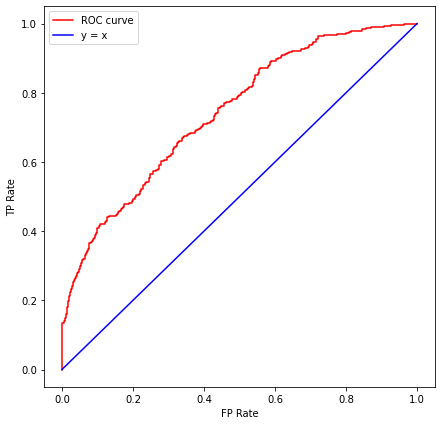

acc_score : 0.776
recall_score : 0.22
precision_score : 0.774
f1_score : 0.343
roc auc value : 0.742


(0.776, 0.343, 0.22, 0.774)

In [36]:
make_roc_curve(y_test, y_pred, y_pred_prob)

### 모델_6정리
- acc_score : 0.776
- recall_score : 0.22
- precision_score : 0.774
- f1_score : 0.343
- roc auc value : 0.742

## C':모델6
    - 6 : id_00
    - 6 : id_02
    - 6 : id_04
    - 6 : id_06

In [37]:
obj = 'fan'
model = '6'

In [38]:
##fan_0
fan_0_id_00_path = '/data/time_series/'+obj+'/'+model
all_fan_0 = glob.glob(fan_0_id_00_path + '/*/*/*')
print(obj+'_'+model+' 개수 : ', len(all_fan_0))
print('\n')

fan_6 개수 :  5550




### sr과 target_sr정하기

In [39]:
sr = 16000
target_sr = 125

### Multi processing

In [40]:
fan_all_model = load_data_using_multi_process(files = all_fan_0, sr = sr, target_sr = target_sr)



아래 리스트에서 샘플링 기법을 선택해주세요. 
 ['abs_max(our_custom)', 'kaiser_best', 'kaiser_fast', 'fft', 'scipy', 'polyphase', 'linear', 'zero_order_hold', 'sinc_best', 'sinc_medium', 'sinc_fastest', 'soxr_vhq', 'soxr_hq', 'soxr_mq', 'soxr_lq', 'soxr_hq', 'soxr_qq']
선택한 기법: soxr_lq

멀티 프로세싱을 시작합니다. 현재 코어 30개 사용 중. 
1.다른 사람과 동시에 돌리지 마세요.
2.함부로 진행중에 중단 하지마세요.
--- 걸린시간: 2.9765872955322266 ---


In [41]:
len(fan_all_model), len(fan_all_model[0][0])

(5550, 1251)

In [42]:
len(fan_all_model)

5550

### 전처리

In [43]:
if len(fan_all_model[0][0]) == (target_sr*10 + 1):
    fan_all_model = [one[0] for one in fan_all_model]
    df = pd.DataFrame(fan_all_model)
df

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,1250
0,-0.000360,0.000853,0.000027,-0.000499,0.000837,-0.001674,0.000307,0.000979,-0.001634,0.001379,...,0.001116,0.000436,-0.000401,0.000445,-0.000653,0.001454,-0.000245,-0.001499,0.000809,0.0
1,-0.001086,0.000985,0.000945,-0.001358,0.000373,-0.000183,0.000309,0.000946,-0.001419,0.000002,...,0.000134,0.000927,-0.000431,0.000859,-0.001342,0.000174,0.001946,-0.001862,-0.000537,0.0
2,-0.000802,-0.002091,-0.001279,0.001322,0.000380,0.000150,0.001583,-0.002071,-0.000858,0.002239,...,0.000081,0.001059,-0.002011,0.001239,0.000583,-0.001195,0.002048,-0.000706,0.000093,0.0
3,-0.000506,0.001325,0.000346,-0.000625,0.001106,-0.000015,-0.000556,0.000748,-0.000443,0.000171,...,-0.000467,-0.000998,0.000268,-0.001514,0.001566,0.001209,-0.001559,0.001015,0.000603,0.0
4,-0.001226,-0.001333,0.001040,0.000282,-0.000790,0.001309,-0.000065,-0.001070,0.000753,-0.000201,...,0.001662,-0.001715,-0.000860,0.001061,-0.000478,0.000585,0.000349,-0.000956,0.000245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545,-0.003358,0.001260,-0.000175,-0.002945,-0.000131,0.000004,0.002636,-0.000036,-0.000123,-0.000354,...,0.002548,0.000429,0.000344,-0.001143,-0.002542,0.001105,0.000697,0.002619,-0.001087,1.0
5546,-0.000804,-0.000624,-0.001183,-0.000623,0.000216,0.001757,0.000654,-0.001382,-0.001207,-0.000639,...,0.002133,0.000519,-0.001659,-0.000656,-0.000508,0.000908,0.001500,-0.000596,-0.001546,1.0
5547,0.001636,0.003068,-0.000737,-0.000752,-0.002758,0.000779,0.003397,-0.001045,-0.001359,-0.000763,...,0.002819,0.002043,-0.003972,-0.001538,-0.000635,0.001800,0.002949,-0.001940,-0.000628,1.0
5548,0.000704,-0.004175,0.000913,-0.000389,0.000365,0.002629,-0.001297,-0.001821,-0.000634,0.000539,...,0.000423,-0.000816,0.000343,0.002192,-0.000650,-0.001727,-0.001771,0.000746,0.000229,1.0


In [44]:
if df.columns[-1] == target_sr*10 :
    df.rename(columns={target_sr*10:'label'}, inplace=True)

df.reset_index(drop=True, inplace=True)
df

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,label
0,-0.000360,0.000853,0.000027,-0.000499,0.000837,-0.001674,0.000307,0.000979,-0.001634,0.001379,...,0.001116,0.000436,-0.000401,0.000445,-0.000653,0.001454,-0.000245,-0.001499,0.000809,0.0
1,-0.001086,0.000985,0.000945,-0.001358,0.000373,-0.000183,0.000309,0.000946,-0.001419,0.000002,...,0.000134,0.000927,-0.000431,0.000859,-0.001342,0.000174,0.001946,-0.001862,-0.000537,0.0
2,-0.000802,-0.002091,-0.001279,0.001322,0.000380,0.000150,0.001583,-0.002071,-0.000858,0.002239,...,0.000081,0.001059,-0.002011,0.001239,0.000583,-0.001195,0.002048,-0.000706,0.000093,0.0
3,-0.000506,0.001325,0.000346,-0.000625,0.001106,-0.000015,-0.000556,0.000748,-0.000443,0.000171,...,-0.000467,-0.000998,0.000268,-0.001514,0.001566,0.001209,-0.001559,0.001015,0.000603,0.0
4,-0.001226,-0.001333,0.001040,0.000282,-0.000790,0.001309,-0.000065,-0.001070,0.000753,-0.000201,...,0.001662,-0.001715,-0.000860,0.001061,-0.000478,0.000585,0.000349,-0.000956,0.000245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545,-0.003358,0.001260,-0.000175,-0.002945,-0.000131,0.000004,0.002636,-0.000036,-0.000123,-0.000354,...,0.002548,0.000429,0.000344,-0.001143,-0.002542,0.001105,0.000697,0.002619,-0.001087,1.0
5546,-0.000804,-0.000624,-0.001183,-0.000623,0.000216,0.001757,0.000654,-0.001382,-0.001207,-0.000639,...,0.002133,0.000519,-0.001659,-0.000656,-0.000508,0.000908,0.001500,-0.000596,-0.001546,1.0
5547,0.001636,0.003068,-0.000737,-0.000752,-0.002758,0.000779,0.003397,-0.001045,-0.001359,-0.000763,...,0.002819,0.002043,-0.003972,-0.001538,-0.000635,0.001800,0.002949,-0.001940,-0.000628,1.0
5548,0.000704,-0.004175,0.000913,-0.000389,0.000365,0.002629,-0.001297,-0.001821,-0.000634,0.000539,...,0.000423,-0.000816,0.000343,0.002192,-0.000650,-0.001727,-0.001771,0.000746,0.000229,1.0


In [45]:
df

,0,1,2,3,4,5,6,7,8,9,...,1241,1242,1243,1244,1245,1246,1247,1248,1249,label
0,-0.000360,0.000853,0.000027,-0.000499,0.000837,-0.001674,0.000307,0.000979,-0.001634,0.001379,...,0.001116,0.000436,-0.000401,0.000445,-0.000653,0.001454,-0.000245,-0.001499,0.000809,0.0
1,-0.001086,0.000985,0.000945,-0.001358,0.000373,-0.000183,0.000309,0.000946,-0.001419,0.000002,...,0.000134,0.000927,-0.000431,0.000859,-0.001342,0.000174,0.001946,-0.001862,-0.000537,0.0
2,-0.000802,-0.002091,-0.001279,0.001322,0.000380,0.000150,0.001583,-0.002071,-0.000858,0.002239,...,0.000081,0.001059,-0.002011,0.001239,0.000583,-0.001195,0.002048,-0.000706,0.000093,0.0
3,-0.000506,0.001325,0.000346,-0.000625,0.001106,-0.000015,-0.000556,0.000748,-0.000443,0.000171,...,-0.000467,-0.000998,0.000268,-0.001514,0.001566,0.001209,-0.001559,0.001015,0.000603,0.0
4,-0.001226,-0.001333,0.001040,0.000282,-0.000790,0.001309,-0.000065,-0.001070,0.000753,-0.000201,...,0.001662,-0.001715,-0.000860,0.001061,-0.000478,0.000585,0.000349,-0.000956,0.000245,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5545,-0.003358,0.001260,-0.000175,-0.002945,-0.000131,0.000004,0.002636,-0.000036,-0.000123,-0.000354,...,0.002548,0.000429,0.000344,-0.001143,-0.002542,0.001105,0.000697,0.002619,-0.001087,1.0
5546,-0.000804,-0.000624,-0.001183,-0.000623,0.000216,0.001757,0.000654,-0.001382,-0.001207,-0.000639,...,0.002133,0.000519,-0.001659,-0.000656,-0.000508,0.000908,0.001500,-0.000596,-0.001546,1.0
5547,0.001636,0.003068,-0.000737,-0.000752,-0.002758,0.000779,0.003397,-0.001045,-0.001359,-0.000763,...,0.002819,0.002043,-0.003972,-0.001538,-0.000635,0.001800,0.002949,-0.001940,-0.000628,1.0
5548,0.000704,-0.004175,0.000913,-0.000389,0.000365,0.002629,-0.001297,-0.001821,-0.000634,0.000539,...,0.000423,-0.000816,0.000343,0.002192,-0.000650,-0.001727,-0.001771,0.000746,0.000229,1.0


### data split
- Stratified train test split(8:2)

In [46]:


X = df.iloc[:, :target_sr*10]
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify = y,
                                                    test_size = 0.2,
                                                    random_state = 42)
print('X_train 의 크기 : ', X_train.shape)
print('X_test 의 크기 : ', X_test.shape)
print('y_train 의 크기 : ', y_train.shape)
print('y_test 의 크기 : ', y_test.shape)


X_train 의 크기 :  (4440, 1250)
X_test 의 크기 :  (1110, 1250)
y_train 의 크기 :  (4440,)
y_test 의 크기 :  (1110,)


In [47]:
print(y_train.value_counts())

0.0    3260
1.0    1180
Name: label, dtype: int64


In [48]:
print(y_test.value_counts())

0.0    815
1.0    295
Name: label, dtype: int64


### 모델링
- LGBM
    - scale_pos_weight : 0의개수(정상) / 1의개수(비정상)

In [49]:
model = model_lgbm(df)

normal : 4075
abnormal : 1475
scale_pos_weight is 2.76.
Model is ready to running.


In [50]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred_prob = model.predict_proba(X_test)



/package/anaconda3.8/lib/python3.8/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


### ROC커브그리기

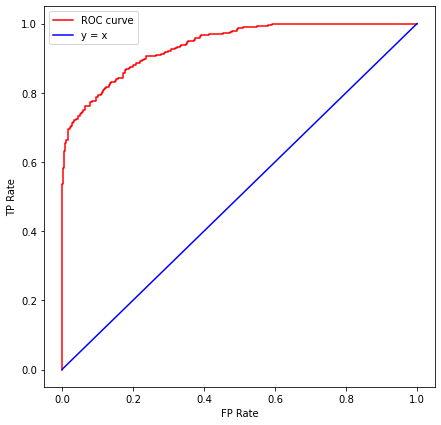

acc_score : 0.898
recall_score : 0.641
precision_score : 0.964
f1_score : 0.77
roc auc value : 0.937


(0.898, 0.77, 0.641, 0.964)

In [51]:
make_roc_curve(y_test, y_pred, y_pred_prob)

### 모델6정리
- acc_score : 0.898
- recall_score : 0.641
- precision_score : 0.964
- f1_score : 0.77
- roc auc value : 0.937

## 총정리

In [52]:
data = pd.read_csv('./ModelingResult/fan_noise.csv')
acc_score = data['accuracy'].values
f1_score = data['f1_score'].values
AUC = data['AUC'].values

[Text(0, 0, '0model'), Text(1, 0, '_6model'), Text(2, 0, '6model')]

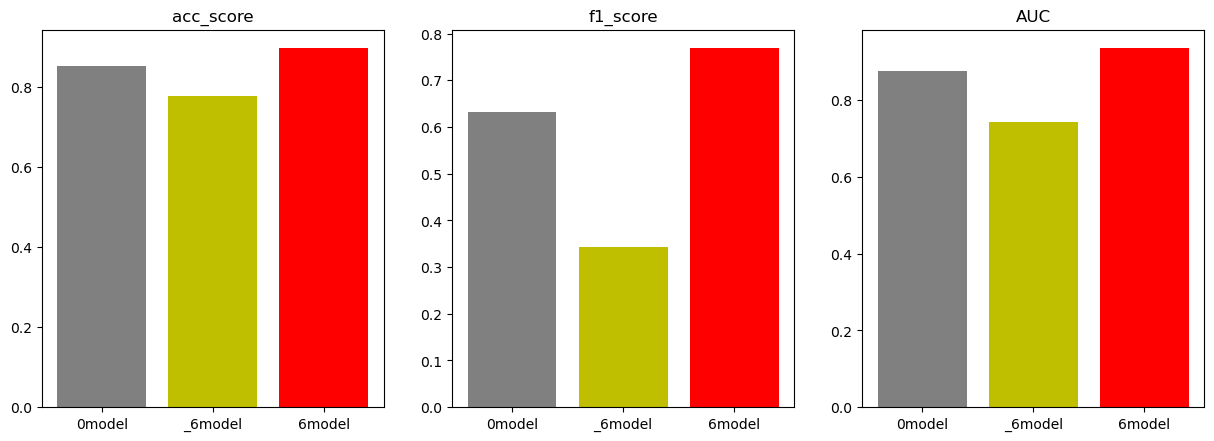

In [53]:
fig = plt.figure(figsize=(15,5), dpi = 100)
axs = fig.subplots(1,3)

## axs[0] : acc_score
X1 = range(0, len(acc_score))
color_li = ['grey'] * len(acc_score)
color_li[np.argmax(acc_score)] = 'r'
color_li[np.argmin(acc_score)] = 'y'
axs[0].bar(X1, acc_score, color=color_li)
axs[0].set_title('acc_score')
axs[0].set_xticks([0,1,2])
axs[0].set_xticklabels(['0model', '_6model', '6model'])

## axs[1] : f1_score
X1 = range(0, len(f1_score))
color_li = ['grey'] * len(f1_score)
color_li[np.argmax(f1_score)] = 'r'
color_li[np.argmin(acc_score)] = 'y'
axs[1].bar(X1, f1_score, color=color_li)
axs[1].set_title('f1_score')
axs[1].set_xticks([0,1,2])
axs[1].set_xticklabels(['0model', '_6model', '6model'])

## axs[2] : AUC
X1 = range(0, len(AUC))
color_li = ['grey'] * len(AUC)
color_li[np.argmax(AUC)] = 'r'
color_li[np.argmin(acc_score)] = 'y'
axs[2].bar(X1, AUC, color=color_li)
axs[2].set_title('AUC')
axs[2].set_xticks([0,1,2])
axs[2].set_xticklabels(['0model', '_6model', '6model'])

In [54]:
import numpy as np
np.mean(data, axis=0)

model        22.000000
accuracy      0.842000
recall        0.446333
precision     0.892333
f1_score      0.581667
AUC           0.851333
dtype: float64

In [55]:
data

,model,accuracy,recall,precision,f1_score,AUC
0,0,0.852,0.478,0.934,0.632,0.875
1,_6,0.776,0.220,0.774,0.343,0.742
2,6,0.898,0.641,0.969,0.770,0.937


해석
- _6에서 recall값이 매우 낮음
    - 실제 정상을 비정상으로 예측함.
- recall 기준으로 보았을때, _6, 0, 6 순으로 recall값이 대략 0.2정도씩 차이가 난다. 
    - 노이즈 있을수록, 실제 정상 데이터를 비정상으로 오분류를 한다.
    